# Classification CAH

In this notebook, the data with 100000 flights is used to conduct the classification.

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.ensemble import GradientBoostingClassifier


In [64]:
%run pretreatment.py
%run ../flight\ phase\ on\ dataset/db.py

database_name = 'descriptors_1.db'

columns_dropped = ['icao', 'icao_airline', 'duration_cruise', 'airport_climb', 'airport_descent']

df, df_meteo, df_operation, airlines_decoder = pretreatment(database_name, columns_dropped, threshold_nb_flights=100, drop_min_max=True)
columns = df.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df, n_estimators=100)
columns_remained = threshold_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns, begin=-3, end=3, n_choices=10)

number of evaluation is 1
number of evaluation is 2


In [65]:
columns_meteo = df_meteo.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df_meteo, n_estimators=100)
columns_remained_meteo = threshold_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns_meteo, begin=-3, end=3, n_choices=10)

number of evaluation is 1


In [66]:
columns_operation = df_operation.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df_operation, n_estimators=100)
columns_remained_operation = threshold_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns_operation, begin=-3, end=3, n_choices=10)

number of evaluation is 1


In [67]:
%run pretreatment.py
print(f'Columns deleted for whole dataset: {columns_deleted(columns, columns_remained)}')
print(f'Columns deleted for meteo sub dataset: {columns_deleted(columns_meteo, columns_remained_meteo)}')
print(f'Columns deleted for meteo sub dataset: {columns_deleted(columns_operation, columns_remained_operation)}')

Columns deleted for whole dataset: ['wind_spind_kt_climb']
Columns deleted for meteo sub dataset: ['wind_spind_kt_descent', 'wind_spind_kt_climb']
Columns deleted for meteo sub dataset: ['avg_vertrate_speed_cruise']


In [174]:
# Standard Scaling (not necessary for random forest)
feature_selection_df = df_filt_10log.dropna()
X = feature_selection_df.iloc[:,:-1]
y = feature_selection_df.loc[:,["airline_cat"]]
X_full = df_filt_10log.iloc[:,:-1]
y_full = df_filt_10log.loc[:,["airline_cat"]]

In [175]:
X_full_selected = X_full[columns_remained]

# Aggregating data

In [177]:
new_df = pd.merge(X_full_selected, y_full, how = 'left', left_index = True, right_index = True)

In [178]:
df_median = new_df.groupby(by = 'airline_cat').median()

In [179]:
df_median.dropna(inplace=True)

In [180]:
df_median.columns

Index(['avg_speed_descent', 'std_speed_descent', 'avg_vertrate_speed_descent',
       'std_vertrate_speed_descent', 'temp_c_descent', 'dewpoint_c_descent',
       'avg_speed_cruise', 'std_speed_cruise', 'std_vertrate_speed_cruise',
       'mean_altitude_cruise', 'avg_speed_climb', 'std_speed_climb',
       'avg_vertrate_speed_climb', 'std_vertrate_speed_climb', 'temp_c_climb',
       'dewpoint_c_climb'],
      dtype='object')

In [181]:
df_median_values = df_median.values
scaler = MaxAbsScaler().fit(df_median_values)
df_median_scaled = scaler.fit_transform(df_median_values)
df_median_scaled = pd.DataFrame(df_median_scaled)

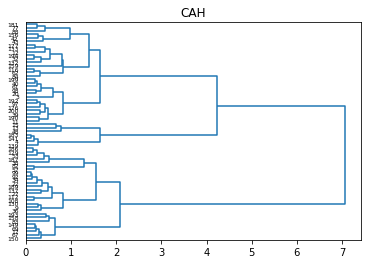

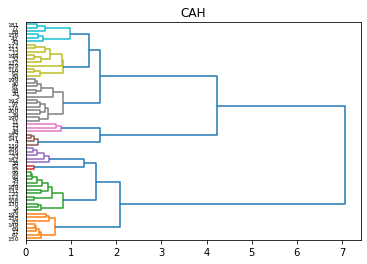

In [182]:
Z = linkage(df_median_scaled,method='ward',metric='euclidean')
threshold = 1
plt.title("CAH")
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=0)
plt.show()
plt.title('CAH')
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=threshold)
plt.show()

In [183]:
import numpy as np
import pandas
groupes_cah = fcluster(Z,t=threshold,criterion='distance')
print(groupes_cah)

[7 5 2 7 8 6 6 1 7 2 2 8 2 2 4 7 7 9 9 6 4 3 7 8 1 1 9 3 1 8 9 2 7 7 2 2 2
 8 4 2 8 8 2 5 5 1 1 9 1 8 7 8 9 5 4 4 2 7 7 1 8 7 7]


In [184]:
idg = np.argsort(groupes_cah)
df1 = pandas.DataFrame(df_median.index[idg],groupes_cah[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')

In [185]:
classif = pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

In [186]:
df_median['group'] = groupes_cah
df_median_scaled['group'] = groupes_cah
feature_diff = df_median_scaled.groupby('group').median().std()

In [187]:
idx = feature_diff.sort_values(ascending=False).index

In [188]:
columns_sorted = np.take(np.array(columns_remained),idx)

In [189]:
# sort the result by the importance of features
df_median.groupby('group').median().loc[:,columns_sorted]

,dewpoint_c_climb,dewpoint_c_descent,temp_c_climb,temp_c_descent,std_speed_cruise,std_vertrate_speed_descent,std_vertrate_speed_cruise,avg_speed_descent,std_speed_climb,avg_vertrate_speed_descent,std_speed_descent,mean_altitude_cruise,avg_vertrate_speed_climb,std_vertrate_speed_climb,avg_speed_climb,avg_speed_cruise
group,,,,,,,,,,,,,,,,
1,12.75,13.00,20.0,21.00,5.077478,2.393086,0.187157,151.400729,38.645294,-5.219734,53.110917,9785.194642,8.655918,4.173486,183.351576,235.948354
2,14.00,14.00,23.5,23.00,2.083347,3.577584,0.188287,154.045732,40.625967,-6.862584,52.591020,10973.161203,8.162802,3.801160,198.259449,231.702457
3,23.50,23.50,27.5,27.50,2.038659,1.760813,0.190743,101.180127,31.980208,-4.580995,30.781511,10973.060541,9.376450,3.782283,182.457229,235.461810
4,20.00,19.00,28.0,27.00,1.030611,3.795669,0.157266,161.785309,51.917348,-7.137370,50.475677,10667.449694,8.936832,3.860404,195.030802,235.617429
5,-17.00,-17.75,-13.0,-14.50,2.728141,3.155217,0.211529,145.282003,43.524981,-6.385196,49.347829,10971.581938,7.891937,3.770581,190.412834,227.882350
6,-12.00,-8.00,-3.0,4.00,1.609461,3.727611,0.130131,162.870446,49.584846,-6.435671,53.231064,8529.501429,9.103333,4.005801,192.313659,233.086667
7,6.00,7.00,10.0,12.00,3.627653,3.983072,0.255801,160.621774,45.846841,-7.098500,51.491892,11262.442304,9.708135,4.221844,186.890317,223.555859
8,1.00,0.75,5.0,5.00,2.865321,3.684956,0.257297,162.579531,44.247203,-7.074470,52.529720,11399.958366,10.218781,4.683434,189.572335,226.283912
9,-0.55,-1.10,8.9,7.45,6.132964,3.706753,0.231517,164.008674,41.394988,-6.838700,56.097395,11034.156365,8.767004,4.285459,196.823736,233.734178


In [190]:
pandas.set_option('display.max_rows', 63)
classif

,airline_cat,0
1,193,West Air (China)
1,83,Etihad Airways
1,149,Shenzhen Airlines
1,17,Air China
1,69,China Southern Airlines
1,67,China Eastern Airlines
1,150,Sichuan Airlines
1,158,Spring Airlines
2,92,GoAir
2,99,IndiGo Airlines
